In [27]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [28]:
# Running the provided base classes

# ======================
# Agent
# ======================
def random_argmax(vector):
    """
    Helper function to select argmax at random, not just first one.
    """
    index = np.random.choice(np.where(vector == vector.max())[0])
    return index


class Agent(object):
    """
    Base class for all bandit agents.
    """

    def __init__(self):
        """Initialize the agent."""
        pass

    def update_observation(self, observation, action, reward):
        """Add an observation to the records."""
        pass

    def pick_action(self, observation):
        """Select an action based upon the policy + observation."""
        pass


# ======================
# Environment
# ======================
class Environment(object):
    """
    Base class for all bandit environments.
    """

    def __init__(self):
        """Initialize the environment."""
        pass

    def get_observation(self):
        """Returns an observation from the environment."""
        pass

    def get_optimal_reward(self):
        """Returns the optimal possible reward for the environment at that point."""
        pass

    def get_expected_reward(self, action):
        """Gets the expected reward of an action."""
        pass

    def get_stochastic_reward(self, action):
        """Gets a stochastic reward for the action."""
        pass

    def advance(self, action, reward):
        """Updating the environment (useful for nonstationary bandit)."""
        pass

    
# ======================
# Experiment
# ======================
class BaseExperiment(object):
    """
    Simple experiment that logs regret and action taken.
    """

    def __init__(self, agent, environment, n_steps,
                 seed=0, rec_freq=1, unique_id='NULL'):
        """
        Setting up the experiment.
        Note that unique_id should be used to identify the job later for analysis.
        """
        
        self.agent = agent
        self.environment = environment
        
        self.n_steps = n_steps
        self.seed = seed
        self.unique_id = unique_id

        self.results = []
        self.data_dict = {}
        self.rec_freq = rec_freq


    def run_step(self, t):
        """
        Run the experiment for one step.
        """
        # Evolve the bandit (potentially contextual) for one step and pick action
        observation = self.environment.get_observation()
        action = self.agent.pick_action(observation)

        # Compute useful stuff for regret calculations
        optimal_reward = self.environment.get_optimal_reward()
        expected_reward = self.environment.get_expected_reward(action)
        reward = self.environment.get_stochastic_reward(action)

        # Update the agent using realized rewards + bandit learing
        self.agent.update_observation(observation, action, reward)

        # Log whatever we need for the plots we will want to use.
        instant_regret = optimal_reward - expected_reward
        self.cum_regret += instant_regret

        # Advance the environment (used in nonstationary experiment)
        self.environment.advance(action, reward)

        if not (t + 1) % self.rec_freq:
            self.data_dict = {'t': (t + 1),
                              'instant_regret': instant_regret,
                              'cum_regret': self.cum_regret,
                              'action': action,
                              'unique_id': self.unique_id}
            self.results.append(self.data_dict)


    def run_experiment(self):
        """
        Run the experiment for n_steps and collect data.
        """
        np.random.seed(self.seed)
        self.cum_regret = 0
        self.cum_optimal = 0

        for t in range(self.n_steps):
            self.run_step(t)

        self.results = pd.DataFrame(self.results)

# Now, let's extend the Environment for the linear bandit problem

class LinearBanditEnvironment(Environment):
    def __init__(self, theta_star, a_star, a_prime, noise_scale=0.5):
        """
        Initialize the linear bandit environment.
        """
        super(LinearBanditEnvironment, self).__init__()
        self.theta_star = theta_star
        self.a_star = a_star
        self.a_prime = np.concatenate(([0], a_prime))
        self.noise_scale = noise_scale

    def get_observation(self):
        """
        Returns an observation from the environment.
        In this case, no context, so return None.
        """
        return None

    def get_optimal_reward(self):
        """
        Returns the optimal possible reward for the environment at that point.
        """
        return np.dot(self.a_star, self.theta_star)

    def get_expected_reward(self, action):
        """
        Gets the expected reward of an action.
        """
        if action == 0:  # Optimal arm
            return np.dot(self.a_star, self.theta_star)
        elif action == 1:  # Suboptimal arm
            return np.dot(self.a_prime, self.theta_star)
        else:
            raise ValueError("Invalid action.")

    def get_stochastic_reward(self, action):
        """
        Gets a stochastic reward for the action.
        """
        expected_reward = self.get_expected_reward(action)
        noise = np.random.uniform(-self.noise_scale, self.noise_scale)
        return expected_reward + noise

    def advance(self, action, reward):
        """
        Updating the environment (useful for nonstationary bandit).
        In this case, environment is stationary, so no update.
        """
        pass

# Setting up the environment parameters and testing
d = 100
theta_star = np.concatenate(([1, 1], np.zeros(d-2)))
a_star = np.concatenate(([1], np.zeros(d-1)))
a_prime = np.random.randn(d-1)
a_prime = 0.2 * (a_prime / np.linalg.norm(a_prime))

env = LinearBanditEnvironment(theta_star, a_star, a_prime)
observation = env.get_observation()
optimal_reward = env.get_optimal_reward()
expected_reward_0 = env.get_expected_reward(0)
expected_reward_1 = env.get_expected_reward(1)
stochastic_reward_0 = env.get_stochastic_reward(0)
stochastic_reward_1 = env.get_stochastic_reward(1)

observation, optimal_reward, expected_reward_0, expected_reward_1, stochastic_reward_0, stochastic_reward_1


(None,
 1.0,
 1.0,
 -0.0047521415519921895,
 0.7869026180887316,
 0.40113464298009716)

In [29]:
class FeelGoodThompsonSamplingAgent(Agent):
    def __init__(self, d, eta, lambd, m, b, learning_rate):
        super(FeelGoodThompsonSamplingAgent, self).__init__()
        
        self.d = d
        self.eta = eta
        self.lambd = lambd
        self.m = m
        self.b = b
        self.learning_rate = learning_rate
        
        # Initialize the parameter estimate
        self.theta_tilde = np.zeros(d)
        
        # Track the history
        self.history = []

    def _loss_gradient(self, a, r):
        """
        Compute the gradient of the loss function.
        """
        loss_term = self.eta * (r - np.dot(a, self.theta_tilde)) * a
        exploration_term = -self.lambd * np.minimum(self.b, np.dot(a, self.theta_tilde)) * a
        return loss_term + exploration_term

#     def update_observation(self, observation, action, reward):
#         """
#         Update the parameter estimate based on the observation.
#         """
#         # Store the data
#         if action == 0:
#             a = np.concatenate(([1], np.zeros(self.d-1)))
#         else:
#             a = self.history[action-1]['a']
#         self.history.append({'a': a, 'r': reward})
        
#         # SGLD update
#         i = np.random.choice(len(self.history))
#         a_i = self.history[i]['a']
#         r_i = self.history[i]['r']
        
#         grad = self._loss_gradient(a_i, r_i) - (1.0 / (i+1)) * self.m * self.theta_tilde
#         noise = np.random.randn(self.d) * np.sqrt(2 * self.learning_rate / (i+1))
#         self.theta_tilde -= self.learning_rate * grad + noise
        
    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        # Store the action and reward
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            a = self.history[action-1]['a']
        self.history.append({'a': a, 'r': reward})
        
        # SGLD update with corrected Gaussian prior gradient
        i = np.random.choice(len(self.history))
        a_i = self.history[i]['a']
        r_i = self.history[i]['r']
        
        grad_loss = self._loss_gradient(a_i, r_i)
        grad_prior = self.m * self.theta_tilde
        total_grad = grad_loss + grad_prior / (i+1)
        
        noise = np.random.randn(self.d) * np.sqrt(2 * self.learning_rate / (i+1))
        self.theta_tilde -= self.learning_rate * total_grad + noise


    def pick_action(self, observation):
        """
        Pick an action based on Thompson Sampling.
        """
        val_0 = np.dot(np.concatenate(([1], np.zeros(self.d-1))), self.theta_tilde)
        val_1 = np.dot(self.history[-1]['a'] if len(self.history) > 0 else np.zeros(self.d), self.theta_tilde)
        return random_argmax(np.array([val_0, val_1]))



In [52]:
# Instantiate the agent and run a simple experiment
agent = FeelGoodThompsonSamplingAgent(d, eta=1, lambd=0, m=100, b=np.inf, learning_rate=0.01)
experiment = BaseExperiment(agent, env, n_steps=1000)
experiment.run_experiment()
results = experiment.results

results['action'][:200]

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    0
197    0
198    1
199    1
Name: action, Length: 200, dtype: int64

<Axes: xlabel='t'>

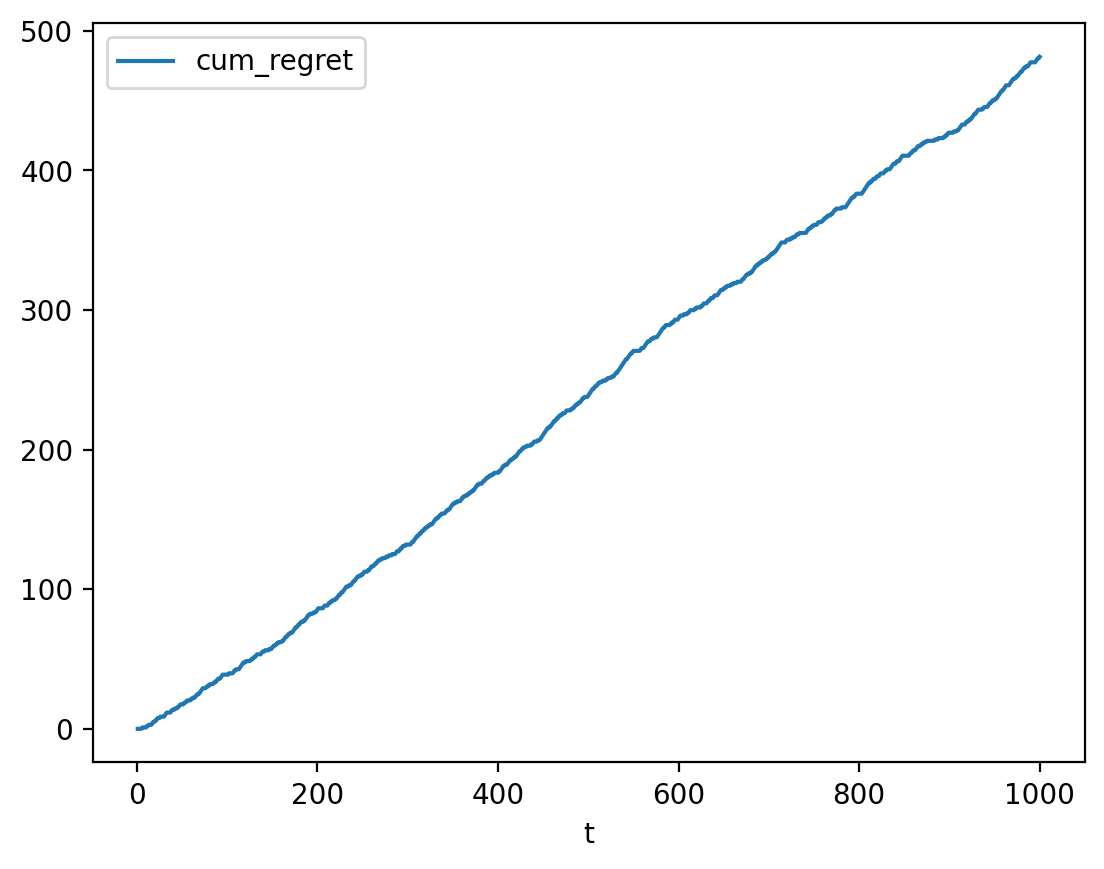

In [50]:
results.plot(x='t', y='cum_regret')

In [36]:
# Setting up the environment parameters and testing
d = 100
theta_star = np.concatenate(([1, 1], np.zeros(d-2)))
a_star = np.concatenate(([1], np.zeros(d-1)))
a_prime = np.random.randn(d-1)
a_prime = 0.2 * (a_prime / np.linalg.norm(a_prime))

env = LinearBanditEnvironment(theta_star, a_star, a_prime)
observation = env.get_observation()
optimal_reward = env.get_optimal_reward()
expected_reward_0 = env.get_expected_reward(0)
expected_reward_1 = env.get_expected_reward(1)
stochastic_reward_0 = env.get_stochastic_reward(0)
stochastic_reward_1 = env.get_stochastic_reward(1)

expected_reward_0, expected_reward_1, stochastic_reward_0, stochastic_reward_1

(1.0, 0.029614175878266015, 1.2068520567124827, -0.3319158210735234)

In [33]:
# ######################################################
# Run experiment
# ######################################################
n_simulations = 100
n_steps = 1000
eta = 1
lambd = 0
m = 100
b = np.inf
learning_rate = 0.01

instant_regrets = []
cum_regrets = []
actions = []

for i in range(n_simulations):
    agent = FeelGoodThompsonSamplingAgent(d, eta=eta, lambd=lambd, m=m, 
                                          b=np.inf, learning_rate=learning_rate)
    experiment = BaseExperiment(agent, env, n_steps=n_steps)
    experiment.run_experiment()
    instant_regrets.append(experiment.results['instant_regret'].values)
    cum_regrets.append(experiment.results['cum_regret'].values)
    actions.append(experiment.results['action'].values)

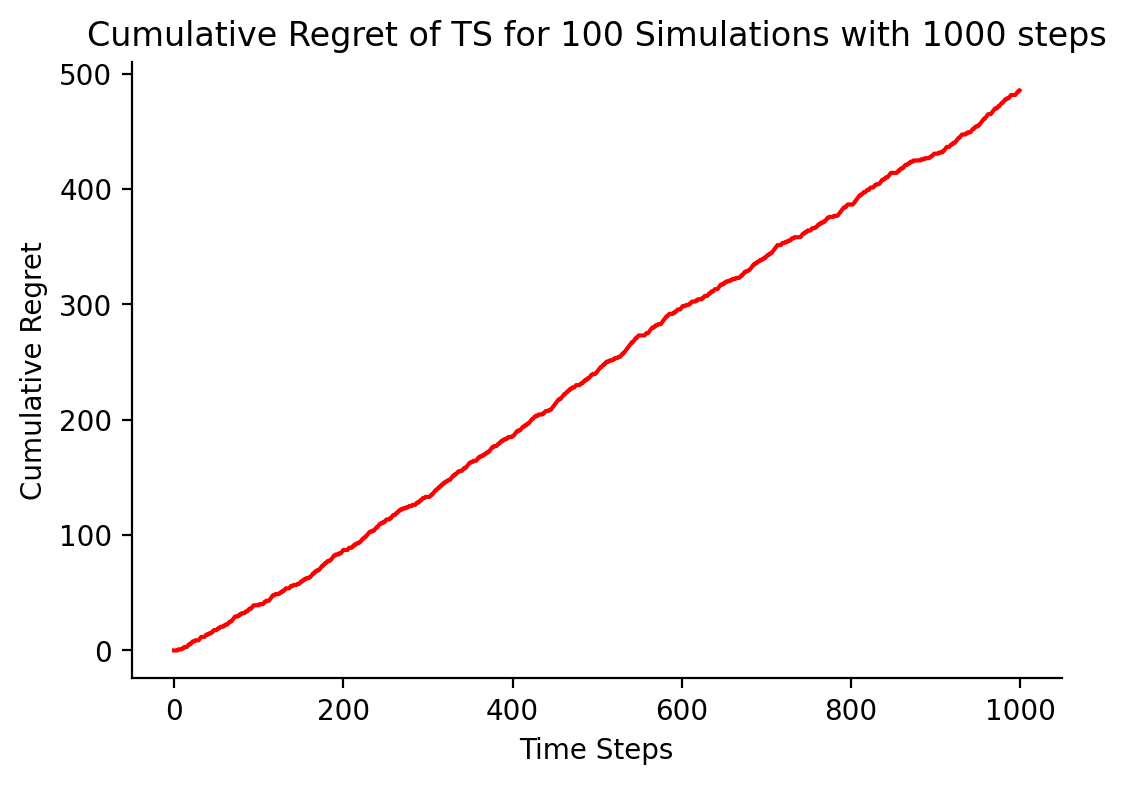

In [34]:
# ######################################################
# Plot
# ######################################################
plt.figure(figsize=(6, 4))
plt.plot(range(n_steps), np.mean(cum_regrets, axis=0), c='r')
plt.title(f'Cumulative Regret of TS for {n_simulations} Simulations with {n_steps} steps')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
sea.despine()

In [61]:
class CorrectedClosedFormGaussianThompsonSamplingAgent(Agent):
    def __init__(self, d, m, sigma=1):
        super(CorrectedClosedFormGaussianThompsonSamplingAgent, self).__init__()
        self.d = d
        self.sigma = sigma  # noise standard deviation
        
        # Prior initialization
        self.mu = np.zeros(self.d)
        self.Sigma_inv = np.eye(self.d) / m  # Inverse of the covariance matrix
        
        # History of mu values for visualization
        self.mu_history = []
        
        # Initializing a'
        self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))

    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            a = self.a_prime
        
        # Closed-form Gaussian update
        self.Sigma_inv += (1 / self.sigma**2) * np.outer(a, a)
        self.mu = np.linalg.inv(self.Sigma_inv).dot(self.Sigma_inv.dot(self.mu) + (reward / self.sigma**2) * a)
        
        # Append the current mu to the history
        self.mu_history.append(self.mu.copy())

    def pick_action(self, observation):
        """Select an action based on the current estimate of theta."""
        # The two actions
        a_star = np.concatenate(([1], np.zeros(self.d-1)))
        
        # Sample theta from the current posterior
        theta_sample = np.random.multivariate_normal(self.mu, np.linalg.inv(self.Sigma_inv))
        
        # Compute the expected rewards for both actions
        reward_star = np.dot(a_star, theta_sample)
        reward_prime = np.dot(self.a_prime, theta_sample)
        
        # Return the action with the higher expected reward
        return 0 if reward_star > reward_prime else 1

# For demonstration purposes, let's instantiate and run the corrected agent
corrected_closed_form_gaussian_ts_agent = CorrectedClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
corrected_closed_form_gaussian_ts_experiment = BaseExperiment(corrected_closed_form_gaussian_ts_agent, env, n_steps=1000)
corrected_closed_form_gaussian_ts_experiment.run_experiment()

# Extracting the cumulative regrets for the corrected agent
corrected_closed_form_gaussian_cum_regrets = corrected_closed_form_gaussian_ts_experiment.results['cum_regret'].values

corrected_closed_form_gaussian_cum_regrets


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.97038582, 0.97038582, 0.97038582, 0.97038582,
       0.97038582, 0.97038582, 0.97038582, 0.97038582, 0.97038582,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077

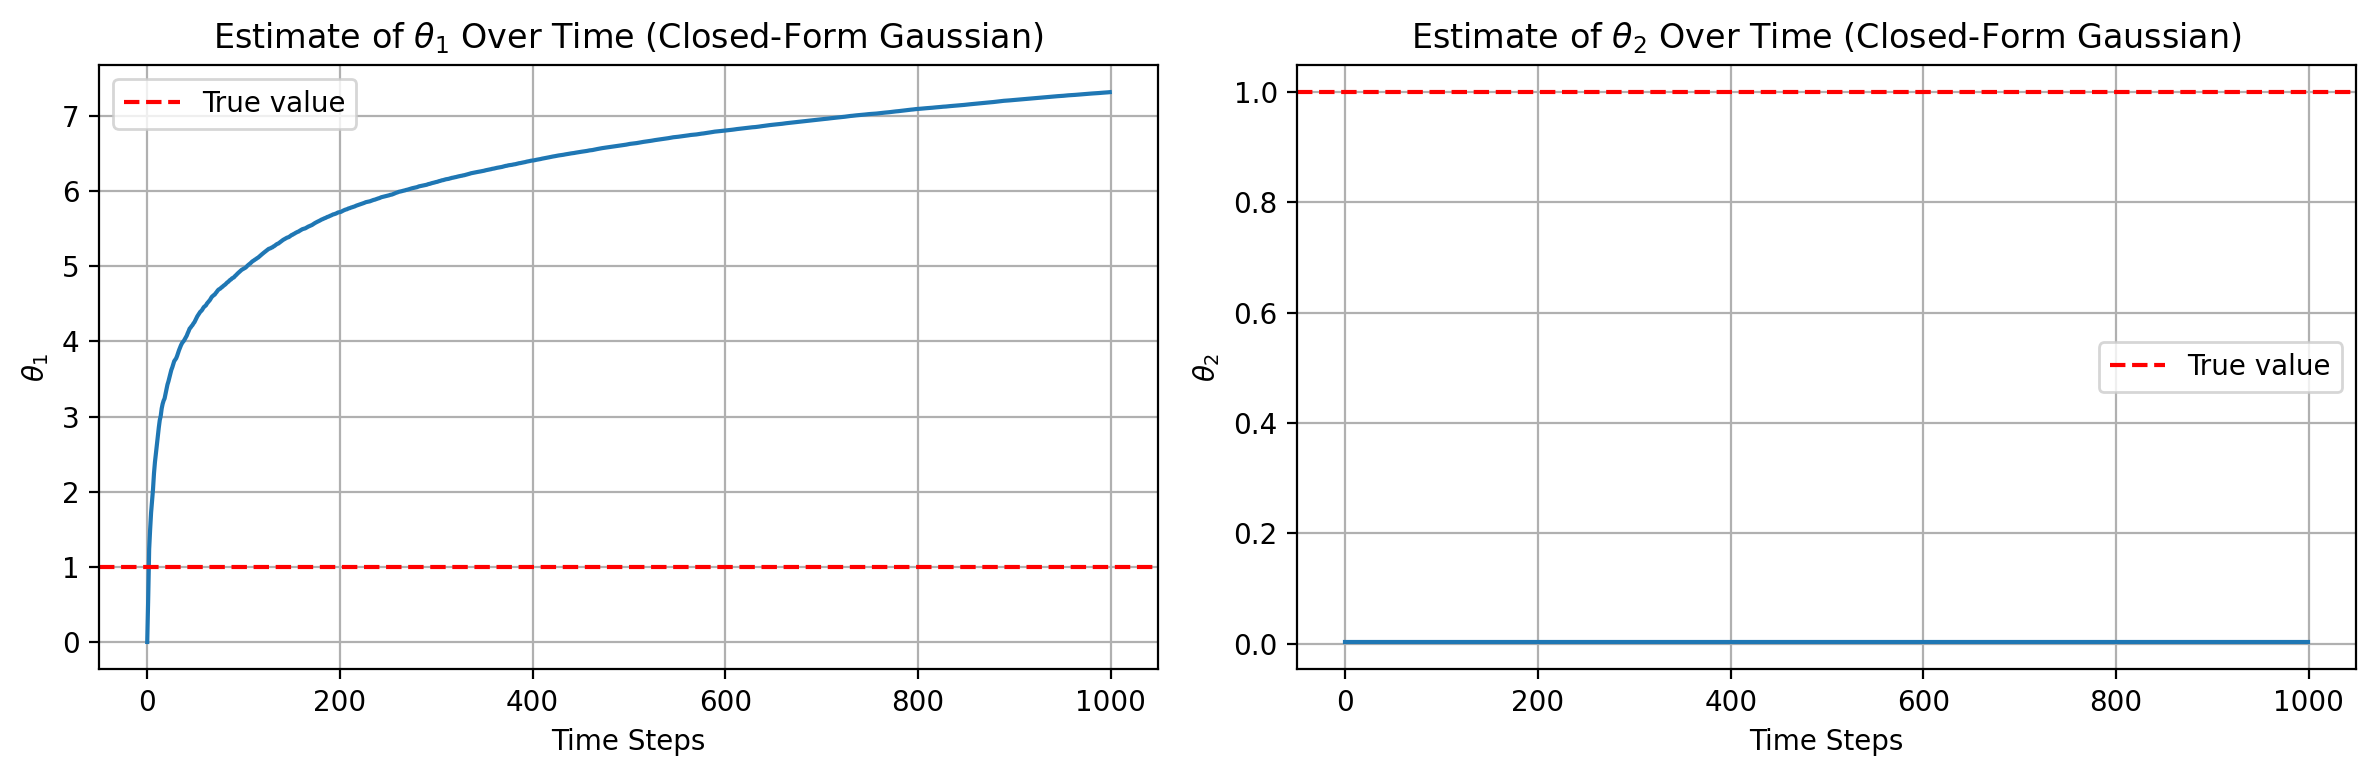

In [62]:
closed_form_gaussian_ts_agent = CorrectedClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
closed_form_gaussian_ts_experiment = BaseExperiment(closed_form_gaussian_ts_agent, env, n_steps=1000)
closed_form_gaussian_ts_experiment.run_experiment()

# Plotting the history of mu values
plt.figure(figsize=(12, 4))

# Theta dimension 1
plt.subplot(1, 2, 1)
plt.plot([theta[0] for theta in closed_form_gaussian_ts_agent.mu_history])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_1$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_1$')
plt.legend()
plt.grid(True)

# Theta dimension 2
plt.subplot(1, 2, 2)
plt.plot([theta[1] for theta in closed_form_gaussian_ts_agent.mu_history])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_2$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_2$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

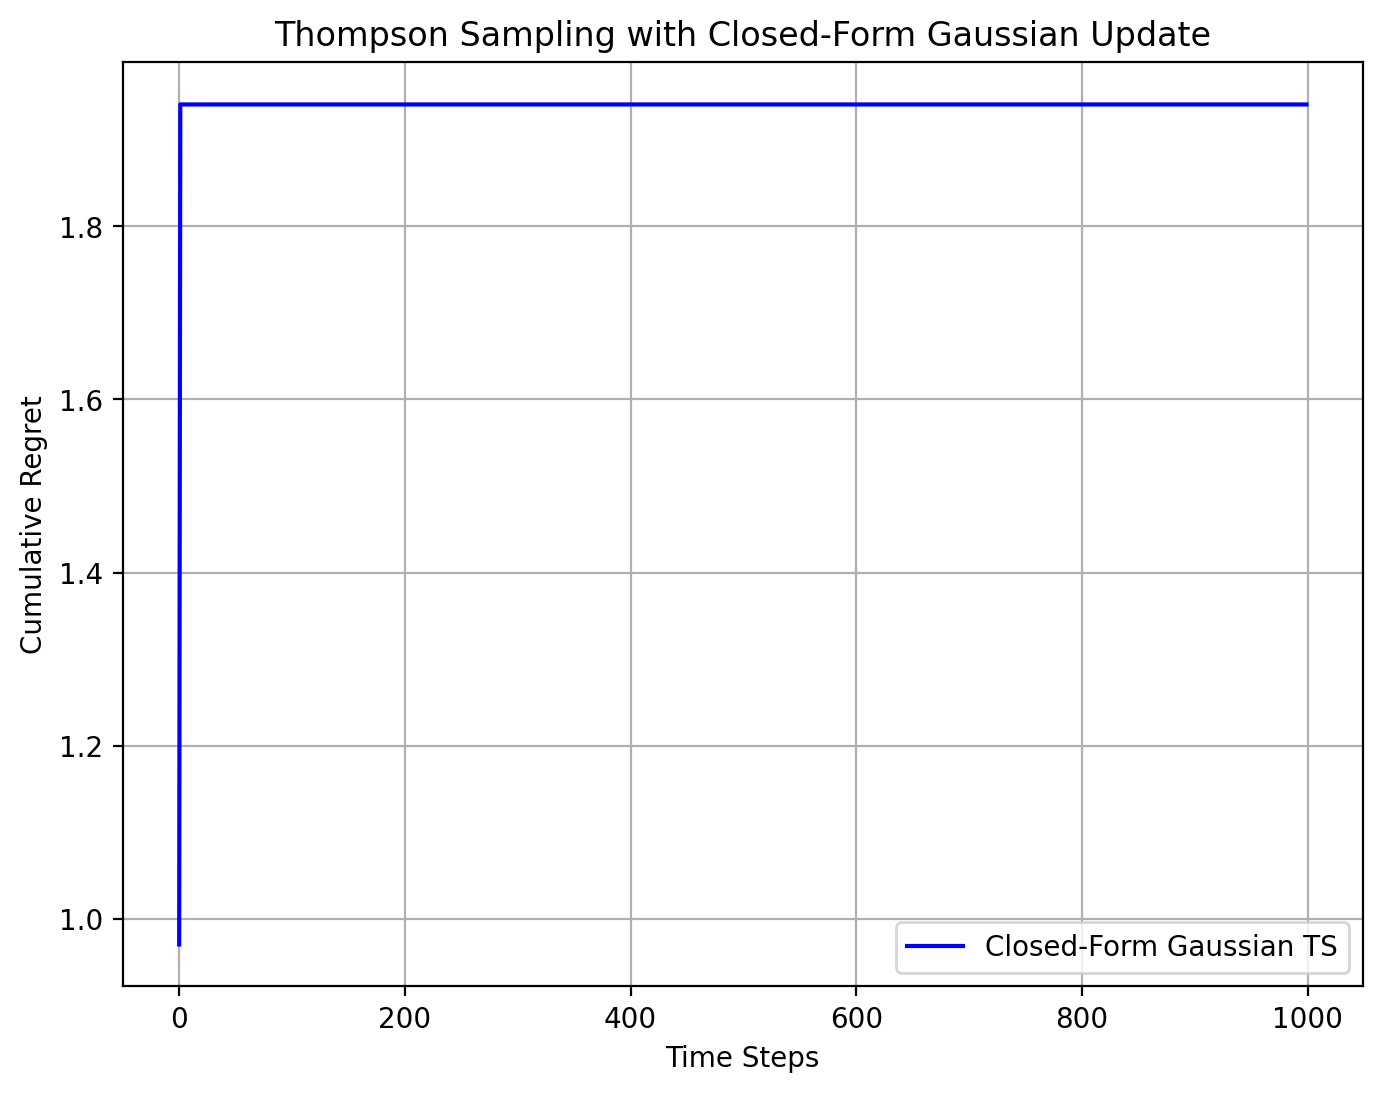

In [53]:
class ClosedFormGaussianThompsonSamplingAgent(Agent):
    def __init__(self, d, m, sigma=1):
        super(ClosedFormGaussianThompsonSamplingAgent, self).__init__()
        self.d = d
        self.sigma = sigma  # noise standard deviation
        
        # Prior initialization
        self.mu = np.zeros(self.d)
        self.Sigma_inv = np.eye(self.d) / m  # Inverse of the covariance matrix

    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            # If history is empty, randomly initialize a'
            if not hasattr(self, 'a_prime'):
                self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))
            a = self.a_prime
        
        # Closed-form Gaussian update
        self.Sigma_inv += (1 / self.sigma**2) * np.outer(a, a)
        self.mu = np.linalg.inv(self.Sigma_inv).dot(self.Sigma_inv.dot(self.mu) + (reward / self.sigma**2) * a)

    def pick_action(self, observation):
        """Select an action based on the current estimate of theta."""
        # The two actions
        a_star = np.concatenate(([1], np.zeros(self.d-1)))
        if not hasattr(self, 'a_prime'):
            self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))
        
        # Sample theta from the current posterior
        theta_sample = np.random.multivariate_normal(self.mu, np.linalg.inv(self.Sigma_inv))
        
        # Compute the expected rewards for both actions
        reward_star = np.dot(a_star, theta_sample)
        reward_prime = np.dot(self.a_prime, theta_sample)
        
        # Return the action with the higher expected reward
        return 0 if reward_star > reward_prime else 1

# Run a simulation with the Thompson Sampling agent with closed-form Gaussian update
closed_form_gaussian_ts_agent = ClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
closed_form_gaussian_ts_experiment = BaseExperiment(closed_form_gaussian_ts_agent, env, n_steps=1000)
closed_form_gaussian_ts_experiment.run_experiment()

# Extract cumulative regrets
closed_form_gaussian_cum_regrets = closed_form_gaussian_ts_experiment.results['cum_regret'].values

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(closed_form_gaussian_cum_regrets, label="Closed-Form Gaussian TS", color='b')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("Thompson Sampling with Closed-Form Gaussian Update")
plt.legend()
plt.grid(True)
plt.show()



In [59]:
import numpy as np

class ClosedFormGaussianThompsonSamplingAgent(Agent):
    def __init__(self, d, m, sigma=1):
        super(ClosedFormGaussianThompsonSamplingAgent, self).__init__()
        self.d = d
        self.sigma = sigma  # noise standard deviation
        
        # Prior initialization
        self.mu = np.zeros(self.d)
        self.Sigma_inv = np.eye(self.d) / m  # Inverse of the covariance matrix
        
        # History of mu values for visualization
        self.mu_history = []

    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            # If history is empty, randomly initialize a'
            if not hasattr(self, 'a_prime'):
                self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))
            a = self.a_prime
        
        # Closed-form Gaussian update
        self.Sigma_inv += (1 / self.sigma**2) * np.outer(a, a)
        self.mu = np.linalg.inv(self.Sigma_inv).dot(self.Sigma_inv.dot(self.mu) + (reward / self.sigma^2) * a)
        
        # Append the current mu to the history
        self.mu_history.append(self.mu.copy())

    def pick_action(self, observation):
        """Select an action based on the current estimate of theta."""
        # The two actions
        a_star = np.concatenate(([1], np.zeros(self.d-1)))
        if not hasattr(self, 'a_prime'):
            self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))
        
        # Sample theta from the current posterior
        theta_sample = np.random.multivariate_normal(self.mu, np.linalg.inv(self.Sigma_inv))
        
        # Compute the expected rewards for both actions
        reward_star = np.dot(a_star, theta_sample)
        reward_prime = np.dot(self.a_prime, theta_sample)
        
        # Return the action with the higher expected reward
        return 0 if reward_star > reward_prime else 1


In [60]:
# Run a simulation with the Thompson Sampling agent with closed-form Gaussian update
closed_form_gaussian_ts_agent = ClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
closed_form_gaussian_ts_experiment = BaseExperiment(closed_form_gaussian_ts_agent, env, n_steps=1000)
closed_form_gaussian_ts_experiment.run_experiment()

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

AttributeError: 'ClosedFormGaussianThompsonSamplingAgent' object has no attribute 'mu_history'

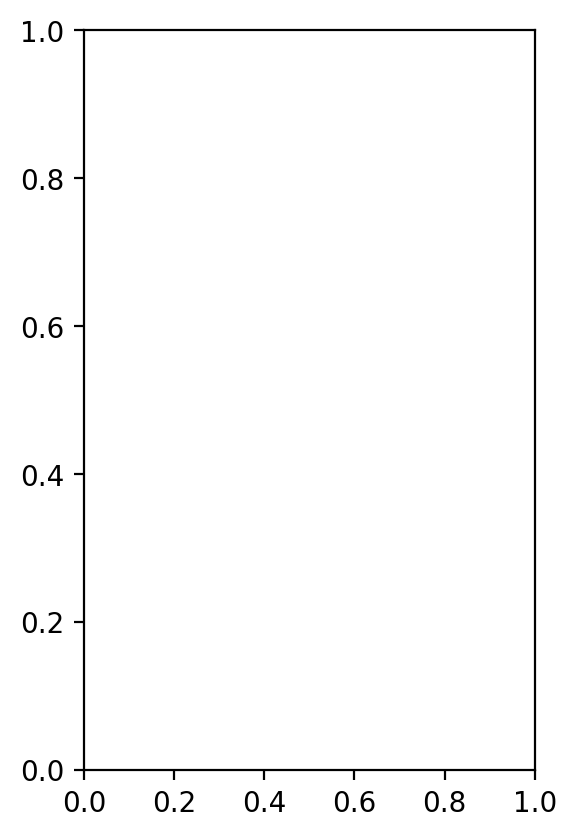

In [58]:
# Theta dimension 1
plt.subplot(1, 2, 1)
plt.plot([theta[0] for theta in closed_form_gaussian_ts_agent.mu_history])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_1$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_1$')
plt.legend()
plt.grid(True)

# Theta dimension 2
plt.subplot(1, 2, 2)
plt.plot([theta[1] for theta in closed_form_gaussian_ts_agent.mu_history])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_2$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_2$')
plt.legend()
plt.grid(True)


In [55]:
closed_form_gaussian_cum_regrets

array([0.97038582, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165, ...

array([0.97038582, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077165,
       1.94077165, 1.94077165, 1.94077165, 1.94077165, 1.94077

In [ ]:
    Add an initialization of self.mu_history = [] in the __init__ method.
    At the end of the update_observation method, append a copy of the current mu to mu_history with self.mu_history.append(self.mu.copy()).

IndexError: invalid index to scalar variable.

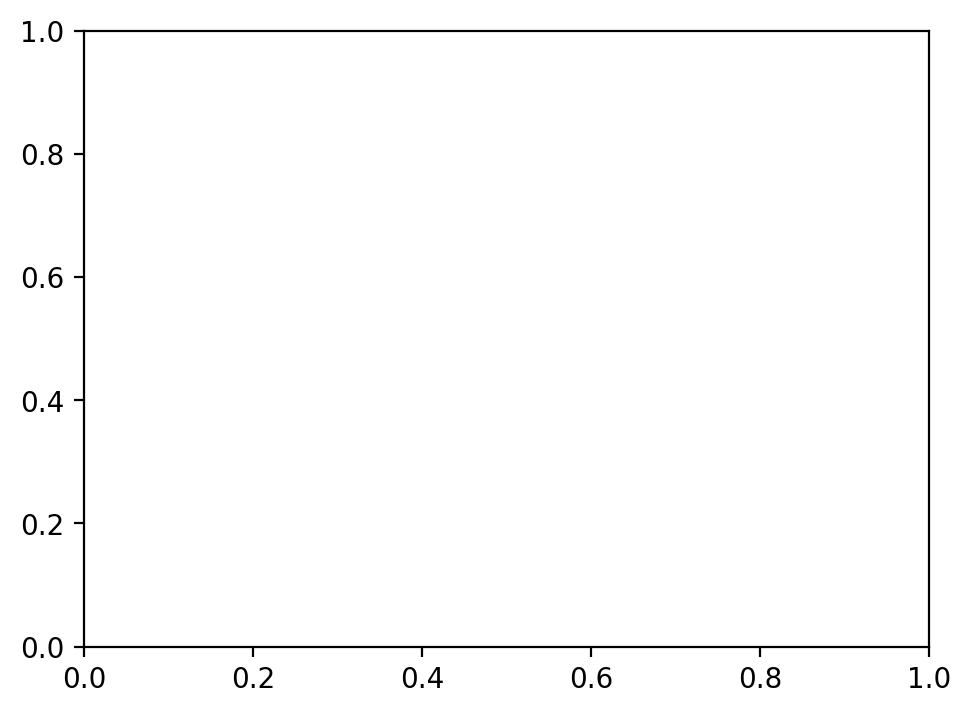

In [56]:
import matplotlib.pyplot as plt

# Extracting the theta estimates from the agent's history
theta_estimates_closed_form_gaussian = [item for item in closed_form_gaussian_ts_agent.mu]

# Plotting the first two dimensions of theta over time
plt.figure(figsize=(12, 4))

# Theta dimension 1
plt.subplot(1, 2, 1)
plt.plot([theta[0] for theta in theta_estimates_closed_form_gaussian])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_1$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_1$')
plt.legend()
plt.grid(True)

# Theta dimension 2
plt.subplot(1, 2, 2)
plt.plot([theta[1] for theta in theta_estimates_closed_form_gaussian])
plt.axhline(y=1, color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_2$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_2$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [64]:
sigma = 1

In [65]:
class OptimizedClosedFormGaussianThompsonSamplingAgent(Agent):
    def __init__(self, d, m, sigma=1):
        super(OptimizedClosedFormGaussianThompsonSamplingAgent, self).__init__()
        self.d = d
        self.sigma = sigma  # noise standard deviation
        
        # Prior initialization
        self.mu = np.zeros(self.d)
        self.Sigma = np.eye(self.d) / m  # covariance matrix
        self.Sigma_inv = np.eye(self.d) * m  # Inverse of the covariance matrix
        
        # History of mu values for visualization
        self.mu_history = []
        
        # Initializing a'
        self.a_prime = np.concatenate(([0], np.random.randn(self.d-1) * 0.2))

    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            a = self.a_prime
        
        # Efficiently compute the new covariance and its inverse using the Sherman-Morrison formula
        v = (1 / self.sigma**2) * self.Sigma.dot(a)
        self.Sigma -= np.outer(v, v) / (1 + (1 / self.sigma**2) * a.dot(self.Sigma).dot(a))
        self.Sigma_inv = self.Sigma_inv + (1 / self.sigma**2) * np.outer(a, a)

        # Update the mean using the new covariance
        self.mu = self.Sigma.dot(self.Sigma_inv.dot(self.mu) + (reward / self.sigma**2) * a)
        
        # Append the current mu to the history
        self.mu_history.append(self.mu.copy())

    def pick_action(self, observation):
        """Select an action based on the current estimate of theta."""
        # The two actions
        a_star = np.concatenate(([1], np.zeros(self.d-1)))
        
        # Sample theta from the current posterior
        theta_sample = np.random.multivariate_normal(self.mu, self.Sigma)
        
        # Compute the expected rewards for both actions
        reward_star = np.dot(a_star, theta_sample)
        reward_prime = np.dot(self.a_prime, theta_sample)
        
        # Return the action with the higher expected reward
        return 0 if reward_star > reward_prime else 1

# Running the optimized Thompson Sampling with the closed-form Gaussian update
env = LinearBanditEnvironment(theta_star, sigma)
optimized_closed_form_gaussian_ts_agent = OptimizedClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
optimized_closed_form_gaussian_ts_experiment = BaseExperiment(optimized_closed_form_gaussian_ts_agent, env, n_steps=100)
optimized_closed_form_gaussian_ts_experiment.run_experiment()

# Extracting the cumulative regrets for the optimized agent
optimized_closed_form_gaussian_cum_regrets = optimized_closed_form_gaussian_ts_experiment.results['cum_regret'].values

optimized_closed_form_gaussian_cum_regrets


TypeError: LinearBanditEnvironment.__init__() missing 1 required positional argument: 'a_prime'

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define problem parameters
d = 100
theta_star = np.concatenate(([1, 1], np.zeros(d-2)))
sigma = 1

# ######################################################
# Set up Base Classes (Agent, Environment, Experiment)
# ######################################################
# ======================
# Agent
# ======================
def random_argmax(vector):
    """Helper function to select argmax at random, not just first one."""
    index = np.random.choice(np.where(vector == vector.max())[0])
    return index

class Agent(object):
    """Base class for all bandit agents."""
    def __init__(self):
        pass

    def update_observation(self, observation, action, reward):
        """Add an observation to the records."""
        pass

    def pick_action(self, observation):
        """Select an action based upon the policy + observation."""
        pass

# ======================
# Environment
# ======================
class LinearBanditEnvironment(Environment):
    def __init__(self, theta_star, sigma, n_arms):
        super().__init__()
        self.theta_star = theta_star
        self.sigma = sigma
        
        # Initializing the arms
        self.arms = [np.concatenate(([1], np.zeros(len(theta_star)-1)))]  # Optimal arm
        for _ in range(n_arms - 1):  # Suboptimal arms
            suboptimal_arm = np.random.randn(d) * 0.2
            suboptimal_arm[0:2] = np.clip(suboptimal_arm[0:2], -0.8, 0.8)
            self.arms.append(suboptimal_arm)
        
    def get_observation(self):
        return {'arms': self.arms}
    
    def get_optimal_reward(self):
        a_star = np.concatenate(([1], np.zeros(len(self.theta_star)-1)))
        return np.dot(a_star, self.theta_star)
    
    def get_expected_reward(self, action):
        if action == 0:
            a = np.concatenate(([1], np.zeros(len(self.theta_star)-1)))
        else:
            a = self.a_prime
        return np.dot(a, self.theta_star)
    
    def get_stochastic_reward(self, action):
        expected_reward = self.get_expected_reward(action)
        return expected_reward + np.random.uniform(-0.5, 0.5)
    
    def advance(self, action, reward):
        pass

# ======================
# Experiment
# ======================
class BaseExperiment(object):
    """Simple experiment that logs regret and action taken."""
    def __init__(self, agent, environment, n_steps, seed=0, rec_freq=1, unique_id='NULL'):
        self.agent = agent
        self.environment = environment
        self.n_steps = n_steps
        self.seed = seed
        self.unique_id = unique_id
        self.results = []
        self.data_dict = {}
        self.rec_freq = rec_freq

    def run_step(self, t):
        """Run the experiment for one step."""
        observation = self.environment.get_observation()
        action = self.agent.pick_action(observation)
        optimal_reward = self.environment.get_optimal_reward()
        expected_reward = self.environment.get_expected_reward(action)
        reward = self.environment.get_stochastic_reward(action)
        self.agent.update_observation(observation, action, reward)
        instant_regret = optimal_reward - expected_reward
        self.cum_regret += instant_regret
        self.environment.advance(action, reward)
        if not (t + 1) % self.rec_freq:
            self.data_dict = {'t': (t + 1),
                              'instant_regret': instant_regret,
                              'cum_regret': self.cum_regret,
                              'action': action,
                              'unique_id': self.unique_id}
            self.results.append(self.data_dict)

    def run_experiment(self):
        """Run the experiment for n_steps and collect data."""
        np.random.seed(self.seed)
        self.cum_regret = 0
        self.cum_optimal = 0
        for t in range(self.n_steps):
            self.run_step(t)
        self.results = pd.DataFrame(self.results)

# Thompson Sampling with Gaussian update
class RefinedClosedFormGaussianThompsonSamplingAgent(Agent):
    def __init__(self, d, m, sigma=1):
        super(RefinedClosedFormGaussianThompsonSamplingAgent, self).__init__()
        self.d = d
        self.sigma = sigma  # noise standard deviation
        
        # Prior initialization
        self.mu = np.zeros(self.d)
        self.Sigma_inv = np.eye(self.d) * m  # Inverse of the covariance matrix
        
        # History of mu values for visualization
        self.mu_history = []

    def update_observation(self, observation, action, reward):
        """Update the parameter estimate based on the observation."""
        if action == 0:
            a = np.concatenate(([1], np.zeros(self.d-1)))
        else:
            a = self.a_prime
        
        # Closed-form Gaussian update for the covariance
        Sigma_new_inv = self.Sigma_inv + (1 / self.sigma**2) * np.outer(a, a)
        
        # Closed-form Gaussian update for the mean
        self.mu = np.linalg.inv(Sigma_new_inv).dot(self.Sigma_inv.dot(self.mu) + (reward / self.sigma**2) * a)
        
        # Update the inverse covariance
        self.Sigma_inv = Sigma_new_inv
        
        # Append the current mu to the history
        self.mu_history.append(self.mu.copy())

    def pick_action(self, observation):
        """Select an action based on the current estimate of theta."""
        
        # Sample theta from the current posterior
        theta_sample = np.random.multivariate_normal(self.mu, np.linalg.inv(self.Sigma_inv))
        
        # Get the arms from the observation (we assume observation contains the arms)
        arms = observation['arms']
        
        # Compute the expected rewards for all arms
        rewards = [np.dot(a, theta_sample) for a in arms]
        
        # Return the action with the highest expected reward
        return np.argmax(rewards)

# Running the refined Thompson Sampling with the closed-form Gaussian update
env = LinearBanditEnvironment(theta_star, sigma, n_arms)
refined_closed_form_gaussian_ts_agent = RefinedClosedFormGaussianThompsonSamplingAgent(d, m=100, sigma=1)
refined_closed_form_gaussian_ts_experiment = BaseExperiment(refined_closed_form_gaussian_ts_agent, env, n_steps=1000)
refined_closed_form_gaussian_ts_experiment.run_experiment()

# Extracting the cumulative regrets for the refined agent
refined_closed_form_gaussian_cum_regrets = refined_closed_form_gaussian_ts_experiment.results['cum_regret'].values

refined_closed_form_gaussian_cum_regrets


NameError: name 'n_arms' is not defined

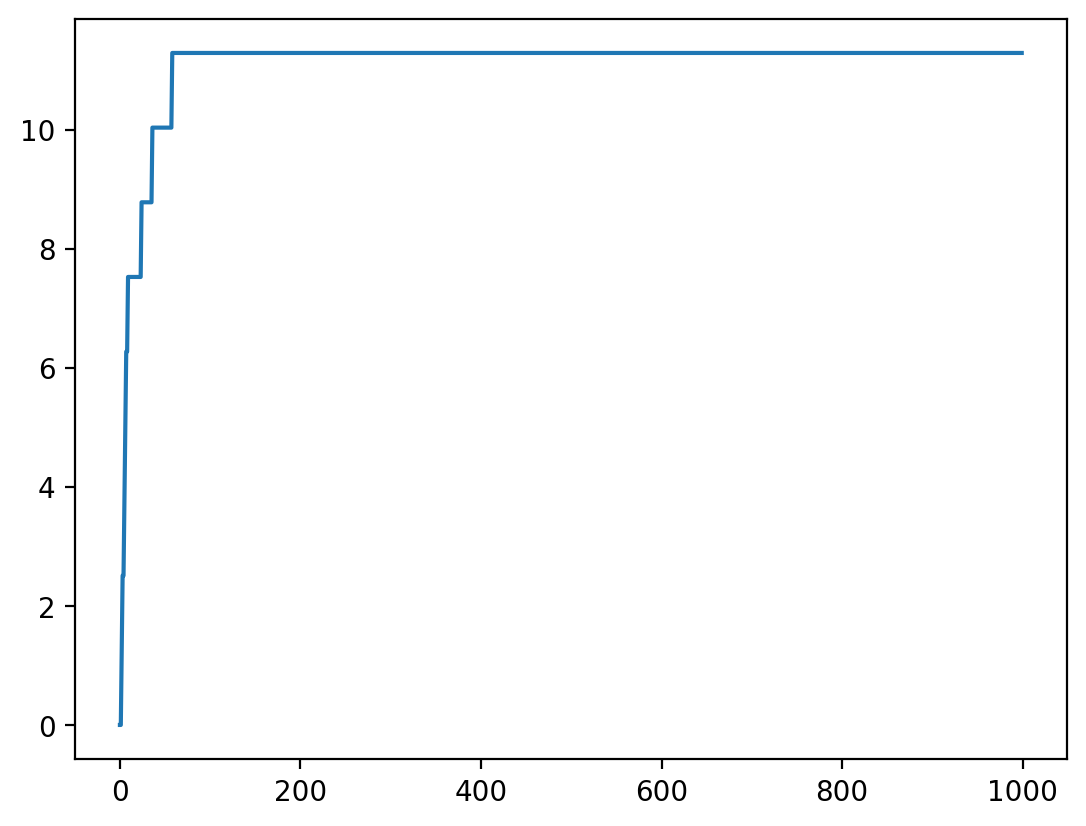

In [67]:
plt.plot(range(len(refined_closed_form_gaussian_cum_regrets)), refined_closed_form_gaussian_cum_regrets)

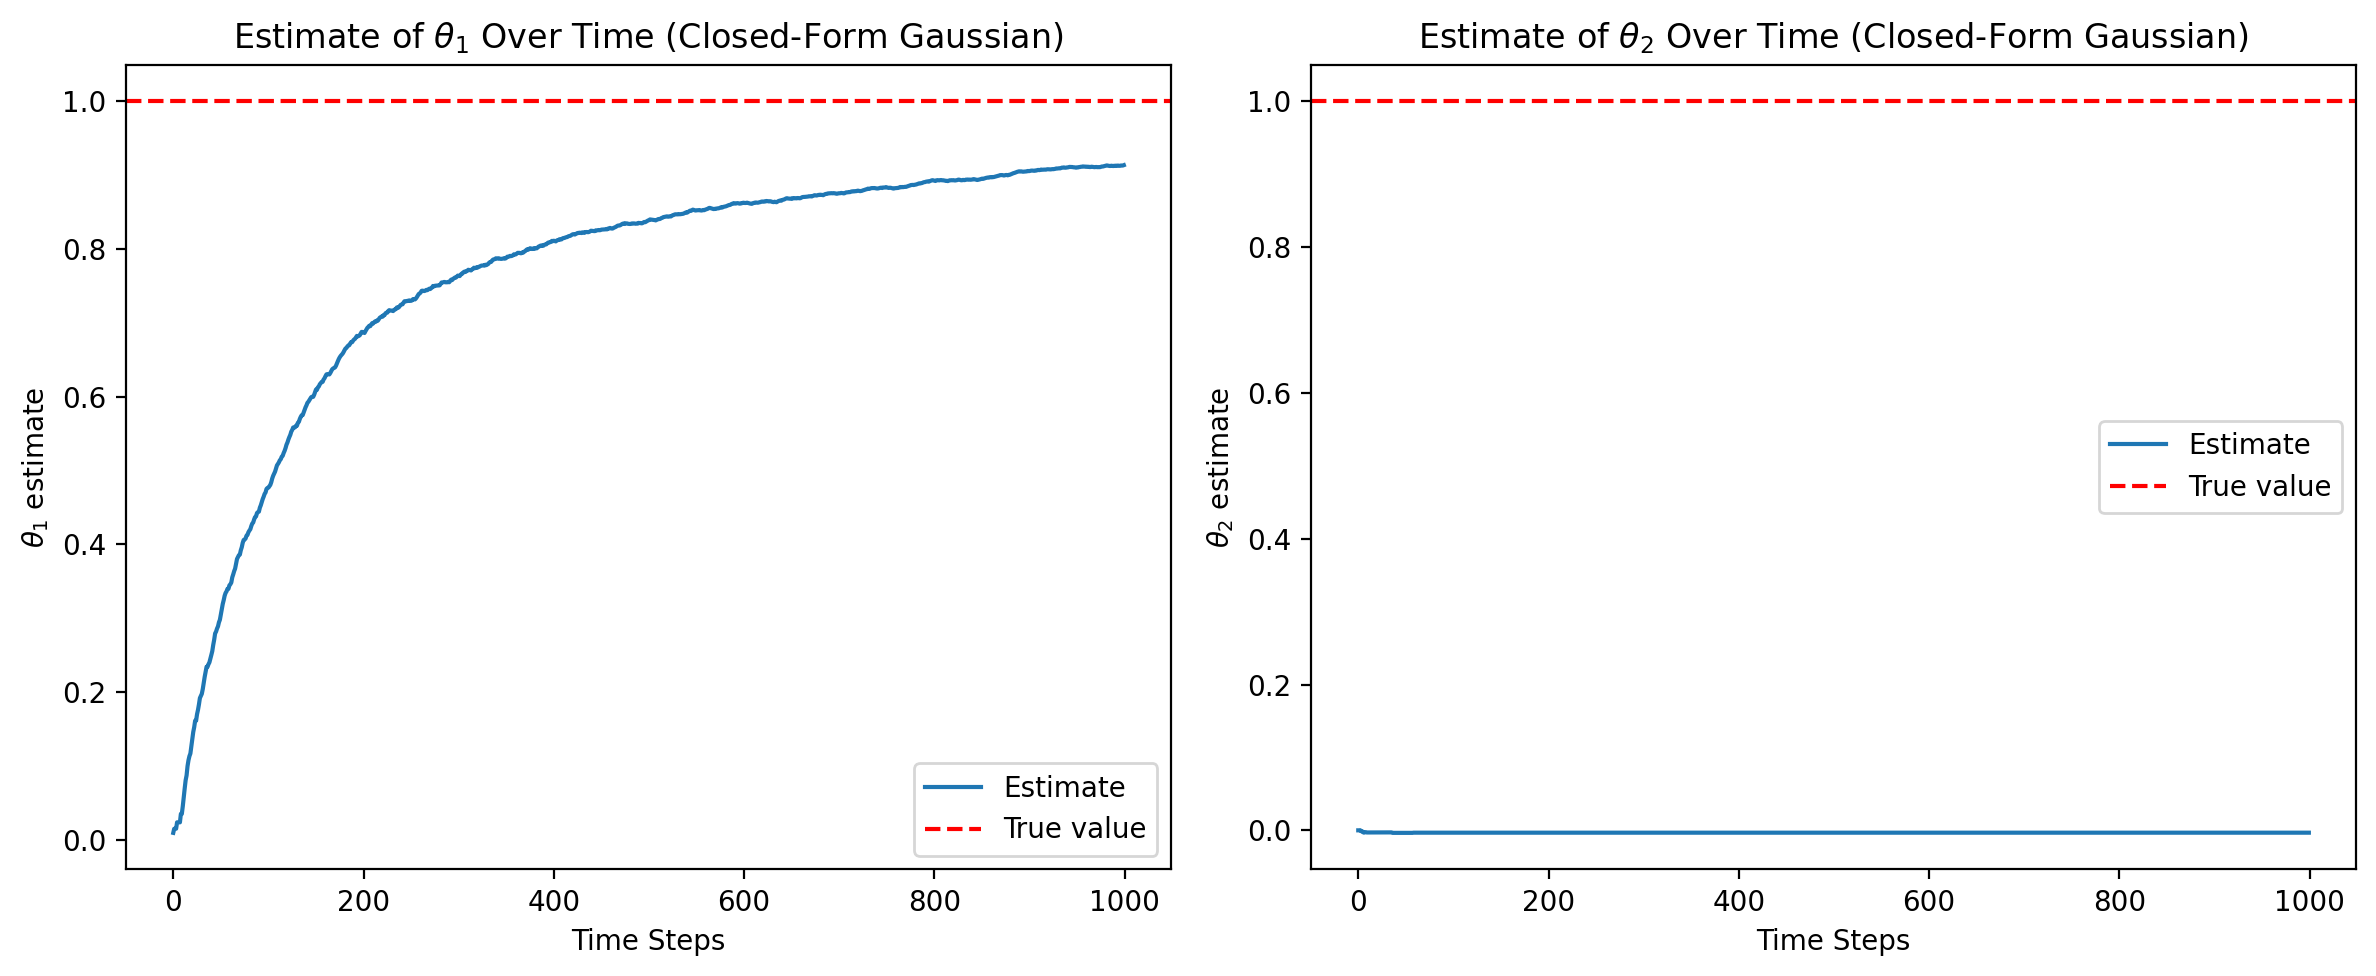

In [68]:
# Extract the history of mu values from the agent
mu_history = refined_closed_form_gaussian_ts_agent.mu_history

# Convert the list of arrays to a 2D array
mu_history_array = np.array(mu_history)

# Plot the history of the first two dimensions of theta
plt.figure(figsize=(12, 5))

# Theta dimension 1
plt.subplot(1, 2, 1)
plt.plot(mu_history_array[:, 0], label="Estimate")
plt.axhline(y=theta_star[0], color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_1$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_1$ estimate')
plt.legend()

# Theta dimension 2
plt.subplot(1, 2, 2)
plt.plot(mu_history_array[:, 1], label="Estimate")
plt.axhline(y=theta_star[1], color='r', linestyle='--', label="True value")
plt.title('Estimate of $\\theta_2$ Over Time (Closed-Form Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('$\\theta_2$ estimate')
plt.legend()

plt.tight_layout()
plt.show()


In [69]:
refined_closed_form_gaussian_ts_experiment.results

,t,instant_regret,cum_regret,action,unique_id
0,1,0.000000,0.000000,0,NULL
1,2,0.000000,0.000000,0,NULL
2,3,1.254114,1.254114,1,NULL
3,4,1.254114,2.508228,1,NULL
4,5,0.000000,2.508228,0,NULL
...,...,...,...,...,...
995,996,0.000000,11.287025,0,NULL
996,997,0.000000,11.287025,0,NULL
997,998,0.000000,11.287025,0,NULL
998,999,0.000000,11.287025,0,NULL
